# Sorting values in an sparse matrix

https://matteding.github.io/2019/04/25/sparse-matrices/

Sorting values in an sparse matrix is not trivial, we want to know how to efficiently have the equivalents of `np.sort` and `np.argsort`

In [1]:
import scipy.sparse as sp
import numpy as np

Let us consider the following example,

In [7]:
np.random.seed(123)
import scipy.sparse as sp
n_samples = 20_000_000
x = sp.random(1, n_samples, density=0.01, format='csr')

In [8]:
x.data

array([0.62885824, 0.36998987, 0.01654456, ..., 0.79507112, 0.55035835,
       0.2160247 ])

In [9]:
x.indices

array([     113,      137,      245, ..., 19999745, 19999843, 19999883],
      dtype=int32)

In [10]:
x[0, x.indices[0]] 

0.6288582392500274

## Generating eficiently a sparse vector

In many applications we might want to cast one row or column of a sparse vector as a dense vector. This can be done with `todense()`,  `ravel()` and `flatten()`.

In [11]:
%%time
x_dense = np.asarray(x.todense()).flatten()

CPU times: user 22.9 ms, sys: 26.2 ms, total: 49.1 ms
Wall time: 47.3 ms


In [12]:
%%time
x_dense = np.asarray(x.todense()).ravel()

CPU times: user 7 ms, sys: 1.08 ms, total: 8.08 ms
Wall time: 6.52 ms


In [13]:
%%timeit
x.todense()

5.59 ms ± 96 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Note that to convert the 2d matrix to a 1d vector `.ravel` is faster than `.flatten()` (with equal output vector)**

In [14]:
%%timeit
x.toarray().flatten()

11.6 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
x.toarray().ravel()

5.52 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
x_ravel = x.toarray().ravel()
x_flatten = x.toarray().flatten()

np.testing.assert_almost_equal(x_ravel, x_flatten)

## Sorting top_k values efficiently a sparse vector (cast as dense)

We can sort all indices of an array and get the positions of the `top_k`.
This is slow

In [17]:
top_k = 10

In [18]:
%%timeit
top_k_argsort =  x_dense.argsort()[-top_k:]

617 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can sort only 10 of the indices of `-x`. Note that this is allocating `-x_dense` at runtime which is bad

In [19]:
%%timeit
top_k_argpartition_allocating = np.argpartition(-x_dense, range(top_k))[0:top_k][::-1]

355 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The best approach consist on using argpartition with a negative value

In [59]:
def get_top_k(x_dense, top_k):
    top_k_argpartition = np.argpartition(x_dense, -top_k)[-top_k:]
    return top_k_argpartition[np.argsort(x_dense[top_k_argpartition])][::-1]

In [21]:
%%timeit
top_k_argpartition = get_top_k(x_dense, top_k)

107 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that all approaches actually return the same result

In [40]:
top_k_argsort =  x_dense.argsort()[-top_k:][::-1]
top_k_argpartition_allocating = np.argpartition(-x_dense, range(top_k))[0:top_k]
top_k_argpartition = get_top_k(x_dense, top_k)

np.testing.assert_almost_equal(top_k_argsort, top_k_argpartition_allocating)
np.testing.assert_almost_equal(top_k_argsort, top_k_argpartition)
np.testing.assert_almost_equal(top_k_argpartition_allocating, top_k_argpartition)

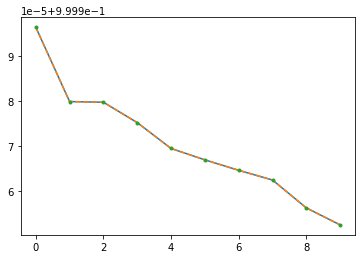

In [43]:
from matplotlib import pyplot as plt
plt.plot(x_dense[top_k_argsort])
plt.plot(x_dense[top_k_argpartition_allocating], '--')
plt.plot(x_dense[top_k_argpartition], '.')

## Sorting top_k values efficiently a sparse vector (no cast as dense)

Note that our previous implementation, the lowest time achieved does not capture the whole process, since it used a dense vector.

We can rethink the solution getting the `top_k` indices without casting to dense

In [44]:
%%time
x_dense = np.asarray(x.todense()).flatten()
top_k_argpartition = get_top_k(x_dense, top_k)

CPU times: user 133 ms, sys: 46.7 ms, total: 180 ms
Wall time: 181 ms


Note that `x.indices` contains the columns (positions since this `x` is a row vector) in which the nonzero data is.

Thefore, we can find the indices of  `x` with highest values (argsort x) and then use those indices to know which features from `x` contain the highest values looking at `x.indices`.

In [45]:
x[0,100:120].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.62885824, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

In [46]:
x.indices

array([     113,      137,      245, ..., 19999745, 19999843, 19999883],
      dtype=int32)

In [47]:
x[0,113]

0.6288582392500274

We can reuse `get_top_k` method to get the column indices from the nonzero values with highest values

In [48]:
get_top_k(x.data, top_k)

array([ 30927,  88535,  11038, 151744, 166040,  37437, 113607, 137501,
        45389,  26679])

now we need to know which are the original column indices using the previous indicies to select the correct indices from `x.indices` and store them in `indices_from_x`.

Then we also need to verify that the indices that we found out without creating a dense vector are actually the same that we found before.

In [49]:
indices_from_x_data = get_top_k(x.data, top_k)
indices_from_x = x.indices[indices_from_x_data]

np.testing.assert_almost_equal(top_k_argpartition,indices_from_x)

In [61]:
def get_top_k_indices(x_sparse, top_k):
    indices_from_x_data = get_top_k(x_sparse.data, top_k)
    indices_from_x = x.indices[indices_from_x_data]
    return indices_from_x

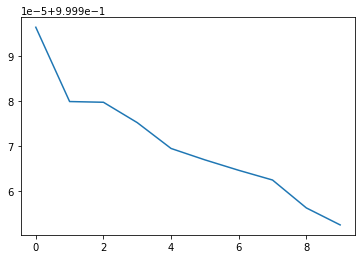

In [62]:
plt.plot(x[0,get_top_k_indices(x, top_k)].toarray().ravel())

In [58]:
%%timeit 
get_top_k_indices(x, top_k)

2.01 ms ± 27.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


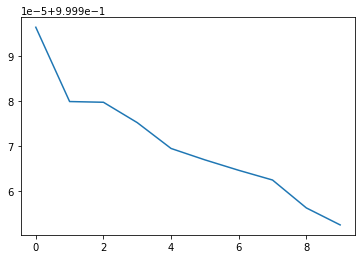

In [57]:
plt.plot(x[0,get_top_k_indices(x, top_k)].toarray().ravel())

## Computing efficiently the mean/sum over rows of a sparse matrix

In [3]:
np.random.seed(123)
import scipy.sparse as sp
n_features = 100_000
n_samples = 100

X = sp.random(n_samples, n_features, density=0.01, format='csr')

In [5]:
X

<100x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [13]:
%%timeit
s = sp.csr_matrix(X.sum(axis=0, dtype=np.int32))

1.21 ms ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can do the sum over rows in a more intelligent way, using the nonzero indices

In [21]:
aux = sp.csr_matrix([[1,0,0,0,2],[3,0,0,2,0]])

In [24]:
aux.toarray()

array([[1, 0, 0, 0, 2],
       [3, 0, 0, 2, 0]])

In [27]:
aux.data

array([1, 2, 3, 2])

In [54]:
aux.indices

array([0, 4, 0, 3], dtype=int32)

In [55]:
aux.indptr

array([0, 2, 4], dtype=int32)

Note that the resulting matrix of aggregating the nonzero values will have at index K the sum of all values in `.data`
that have index K.

In [45]:
unique_indices = np.unique(aux.indices)
unique_indices

array([0, 3, 4], dtype=int32)

We can simply sum the values of the nonzero indices and create a sparse array with those sums

In [47]:
new_data = []
for k in unique_indices:
    val = aux.data[aux.indices==k].sum()
    new_data.append(val)

In [49]:
new_data

[4, 2, 2]

In [60]:
#csr_matrix((data, indices, indptr), [shape=(M, N)])
aux_mean = sp.csr_matrix((new_data, unique_indices, [0,len(new_data)]))
aux_mean

<1x5 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [62]:
aux_mean.toarray()

array([[4, 0, 0, 2, 2]])

In [44]:
aux.sum(axis=0)

matrix([[4, 0, 0, 2, 2]])

In [63]:
def efficient_mean_over_rows(X_sparse):
    new_data = []
    unique_indices = np.unique(X_sparse.indices)
    for k in unique_indices:
        val = X_sparse.data[aux.indices==k].sum()
        new_data.append(val)
        
    X_sum = sp.csr_matrix((new_data, unique_indices, [0,len(new_data)]))
    return X_sum

In [66]:
%%timeit
efficient_mean_over_rows(aux)

51 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [67]:
%%timeit
s = sp.csr_matrix(X.sum(axis=0, dtype=np.int32))

1.21 ms ± 7.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
